In [1]:
! wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
! wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
! pip install spectral

--2022-11-29 20:30:09--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat [following]
--2022-11-29 20:30:14--  https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: ‘Indian_pines_corrected.mat’

Indian_pines_correc 100%[===================>]   5.68M   798KB/s    in 14s     

2022-11-29 20:30:29 (426 KB/s) - ‘Indian_pines_corrected.mat’ saved [5953527/5953527]

URL transformed to HTTPS due to an HSTS policy
--2022-11-29 20:30:29--  https://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.eu

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import spectral
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

In [2]:
class_num = 16
class HybridSN(nn.Module):  
  def __init__(self, in_channels=1, out_channels=class_num):
    super(HybridSN, self).__init__()
    self.conv3d_features = nn.Sequential(
        nn.Conv3d(in_channels,out_channels=8,kernel_size=(7,3,3)),
        nn.ReLU(),
        nn.Conv3d(in_channels=8,out_channels=16,kernel_size=(5,3,3)),
        nn.ReLU(),
        nn.Conv3d(in_channels=16,out_channels=32,kernel_size=(3,3,3)),
        nn.ReLU()
    )

    self.conv2d_features = nn.Sequential(
        nn.Conv2d(in_channels=32 * 18, out_channels=64, kernel_size=(3,3)),
        nn.ReLU()
    )

    self.classifier = nn.Sequential(
        nn.Linear(64 * 17 * 17, 256),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.Linear(128, 16)
    )
 
  def forward(self, x):
    x = self.conv3d_features(x)
    x = x.view(x.size()[0],x.size()[1]*x.size()[2],x.size()[3],x.size()[4])
    x = self.conv2d_features(x)
    x = x.view(x.size()[0],-1)
    x = self.classifier(x)
    return x

In [5]:
# 对高光谱数据 X 应用 PCA 变换
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX

# 对单个像素周围提取 patch 时，边缘像素就无法取了，因此，给这部分像素进行 padding 操作
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

# 在每个像素周围提取 patch ，然后创建成符合 keras 处理的格式
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    # 给 X 做 padding
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

def splitTrainTestSet(X, y, testRatio, randomState):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test

In [6]:
# 地物类别
class_num = 16
X = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
y = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']

# 用于测试样本的比例
test_ratio = 0.1
# 每个像素周围提取 patch 的尺寸
patch_size = 25
# 使用 PCA 降维，得到主成分的数量
pca_components = 30

""" Training dataset"""
class TrainDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = Xtrain.shape[0]
        self.x_data = torch.FloatTensor(Xtrain)
        self.y_data = torch.LongTensor(ytrain)        
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

""" Testing dataset"""
class TestDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = Xtest.shape[0]
        self.x_data = torch.FloatTensor(Xtest)
        self.y_data = torch.LongTensor(ytest)
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len
# 创建 trainloader 和 testloader
train_set_list=[]
test_set_list=[]
for i in range(50):
    while True:
        x1 = random.randint(0, 145)
        x2 = random.randint(0, 145)
        y1 = random.randint(0, 145)
        y2 = random.randint(0, 145)
        if x2 < x1:
            x1, x2 = x2, x1
        if y2 < y1:
            y1, y2 = y2, y1
        if x2 - x1 >= 40 and y2 - y1 >= 40:
            break
    X = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
    y = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']
            
    X_split=X[x1:x2,y1:y2,:]
    y_spilt=y[x1:x2,y1:y2]
    X_pca = applyPCA(X_split, numComponents=pca_components)

    X_pca, y_pca = createImageCubes(X_pca, y_spilt, windowSize=patch_size)

#     print('\n... ... create train & test data ... ...')
    Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X_pca, y_pca, test_ratio,i)
#     print('Xtrain shape: ', Xtrain.shape)
#     print('Xtest  shape: ', Xtest.shape)

    # 改变 Xtrain, Ytrain 的形状，以符合 keras 的要求
    Xtrain = Xtrain.reshape(-1, patch_size, patch_size, pca_components, 1)
    Xtest  = Xtest.reshape(-1, patch_size, patch_size, pca_components, 1)
#     print('before transpose: Xtrain shape: ', Xtrain.shape) 
#     print('before transpose: Xtest  shape: ', Xtest.shape) 

    # 为了适应 pytorch 结构，数据要做 transpose
    Xtrain = Xtrain.transpose(0, 4, 3, 1, 2)
    Xtest  = Xtest.transpose(0, 4, 3, 1, 2)
#     print('after transpose: Xtrain shape: ', Xtrain.shape) 
#     print('after transpose: Xtest  shape: ', Xtest.shape)   
    trainset = TrainDS()
    testset  = TestDS()
    train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=128, shuffle=True, num_workers=2)
#     test_loader  = torch.utils.data.DataLoader(dataset=testset,  batch_size=128, shuffle=False, num_workers=2)
    train_set_list.append(train_loader)
#     test_set_list.append(test_loader)

In [ ]:
# 使用GPU训练，可以在菜单 "代码执行工具" -> "更改运行时类型" 里进行设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 网络放到GPU上
net = HybridSN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 开始训练
count=0
for train_loader in train_set_list:
  total_loss = 0
  print(f"----------{count}----------")
  count+=1
  for epoch in range(10):
      for i, (inputs, labels) in enumerate(train_loader):
          inputs = inputs.to(device)
          labels = labels.to(device)
          # 优化器梯度归零
          optimizer.zero_grad()
          # 正向传播 +　反向传播 + 优化 
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()
      print('[Epoch: %d]   [loss avg: %.4f]   [current loss: %.4f]' %(epoch + 1, total_loss/(epoch+1), loss.item()))
      
print('Finished Training')

----------0----------
[Epoch: 1]   [loss avg: 58.4806]   [current loss: 1.9730]
[Epoch: 2]   [loss avg: 52.3511]   [current loss: 1.4769]
[Epoch: 3]   [loss avg: 42.3825]   [current loss: 0.6872]
[Epoch: 4]   [loss avg: 34.0733]   [current loss: 0.1860]
[Epoch: 5]   [loss avg: 28.1645]   [current loss: 0.1436]
[Epoch: 6]   [loss avg: 23.9124]   [current loss: 0.1079]
[Epoch: 7]   [loss avg: 20.7288]   [current loss: 0.0351]
[Epoch: 8]   [loss avg: 18.3085]   [current loss: 0.0433]
[Epoch: 9]   [loss avg: 16.3872]   [current loss: 0.0240]
[Epoch: 10]   [loss avg: 14.8557]   [current loss: 0.0378]
----------1----------
[Epoch: 1]   [loss avg: 59.2576]   [current loss: 1.2847]
[Epoch: 2]   [loss avg: 41.7208]   [current loss: 0.2893]
[Epoch: 3]   [loss avg: 30.6480]   [current loss: 0.1681]
[Epoch: 4]   [loss avg: 24.0695]   [current loss: 0.0504]
[Epoch: 5]   [loss avg: 19.8159]   [current loss: 0.0743]
[Epoch: 6]   [loss avg: 16.7758]   [current loss: 0.1011]
[Epoch: 7]   [loss avg: 14.

[Epoch: 7]   [loss avg: 99.8648]   [current loss: 2.0448]
[Epoch: 8]   [loss avg: 98.7786]   [current loss: 2.1128]
[Epoch: 9]   [loss avg: 97.9255]   [current loss: 2.2144]
[Epoch: 10]   [loss avg: 97.2434]   [current loss: 2.2085]
----------14----------
[Epoch: 1]   [loss avg: 21.8460]   [current loss: 1.3438]
[Epoch: 2]   [loss avg: 20.0553]   [current loss: 1.3213]
[Epoch: 3]   [loss avg: 18.6841]   [current loss: 0.8725]
[Epoch: 4]   [loss avg: 17.8448]   [current loss: 0.8705]
[Epoch: 5]   [loss avg: 17.2888]   [current loss: 0.9546]
[Epoch: 6]   [loss avg: 16.9010]   [current loss: 0.9648]
[Epoch: 7]   [loss avg: 16.5954]   [current loss: 0.9338]
[Epoch: 8]   [loss avg: 16.3709]   [current loss: 1.0664]
[Epoch: 9]   [loss avg: 16.1731]   [current loss: 0.9305]
[Epoch: 10]   [loss avg: 16.0016]   [current loss: 0.7571]
----------15----------
[Epoch: 1]   [loss avg: 50.3833]   [current loss: 2.8029]
[Epoch: 2]   [loss avg: 43.2233]   [current loss: 2.1863]
[Epoch: 3]   [loss avg: 

In [28]:
X = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
y = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']

X_pca = applyPCA(X, numComponents=pca_components)

X_pca, y = createImageCubes(X_pca, y, windowSize=patch_size)

#     print('\n... ... create train & test data ... ...')
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X_pca, y, test_ratio,i)
#     print('Xtrain shape: ', Xtrain.shape)
#     print('Xtest  shape: ', Xtest.shape)

# 改变 Xtrain, Ytrain 的形状，以符合 keras 的要求
Xtrain = Xtrain.reshape(-1, patch_size, patch_size, pca_components, 1)
Xtest  = Xtest.reshape(-1, patch_size, patch_size, pca_components, 1)
#     print('before transpose: Xtrain shape: ', Xtrain.shape) 
#     print('before transpose: Xtest  shape: ', Xtest.shape) 

# 为了适应 pytorch 结构，数据要做 transpose
Xtrain = Xtrain.transpose(0, 4, 3, 1, 2)
Xtest  = Xtest.transpose(0, 4, 3, 1, 2)
#     print('after transpose: Xtrain shape: ', Xtrain.shape) 
#     print('after transpose: Xtest  shape: ', Xtest.shape)   
trainset = TrainDS()
testset  = TestDS()
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=128, shuffle=True, num_workers=2)
#     test_loader  = torch.utils.data.DataLoader(dataset=testset,  batch_size=128, shuffle=False, num_workers=2)
# train_set_list.append(train_loader)

for epoch in range(100):
      for i, (inputs, labels) in enumerate(train_loader):
          inputs = inputs.to(device)
          labels = labels.to(device)
          # 优化器梯度归零
          optimizer.zero_grad()
          # 正向传播 +　反向传播 + 优化 
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()
      print('[Epoch: %d]   [loss avg: %.4f]   [current loss: %.4f]' %(epoch + 1, total_loss/(epoch+1), loss.item()))

[Epoch: 1]   [loss avg: 220.5313]   [current loss: 1.6770]
[Epoch: 2]   [loss avg: 167.9066]   [current loss: 1.6270]
[Epoch: 3]   [loss avg: 140.5236]   [current loss: 1.8001]
[Epoch: 4]   [loss avg: 119.9113]   [current loss: 0.4666]
[Epoch: 5]   [loss avg: 103.2294]   [current loss: 0.1237]
[Epoch: 6]   [loss avg: 89.6574]   [current loss: 0.1938]
[Epoch: 7]   [loss avg: 78.9200]   [current loss: 0.9355]
[Epoch: 8]   [loss avg: 70.5844]   [current loss: 0.2881]
[Epoch: 9]   [loss avg: 63.4764]   [current loss: 0.0001]
[Epoch: 10]   [loss avg: 57.6286]   [current loss: 0.0130]


In [29]:
# load the original image
X = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
y = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']

height = y.shape[0]
width = y.shape[1]

X = applyPCA(X, numComponents= pca_components)
X = padWithZeros(X, patch_size//2)

# 逐像素预测类别
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        if int(y[i,j]) == 0:
            continue
        else :
            image_patch = X[i:i+patch_size, j:j+patch_size, :]
            image_patch = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1)
            X_test_image = torch.FloatTensor(image_patch.transpose(0, 4, 3, 1, 2)).to(device)                                   
            prediction = net(X_test_image)
            prediction = np.argmax(prediction.detach().cpu().numpy(), axis=1)
            outputs[i][j] = prediction+1
    if i % 20 == 0:
        print('... ... row ', i, ' handling ... ...')

... ... row  0  handling ... ...
... ... row  20  handling ... ...
... ... row  40  handling ... ...
... ... row  60  handling ... ...
... ... row  80  handling ... ...
... ... row  100  handling ... ...
... ... row  120  handling ... ...
... ... row  140  handling ... ...


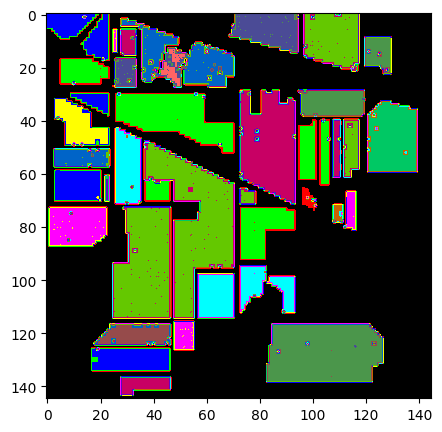

In [30]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))

In [ ]:
torch.save(net.state_dict(), "./indian_model/indian_parameter.pkl")

In [31]:
import os
torch.save(net, os.path.join('.', '50_10_all.pth')) # 保存模型结构和参数

In [8]:
count = 0
# 模型测试
test_loader = test_set_list[0]
for inputs, _ in test_loader:
    inputs = inputs.to(device)
    outputs = net(inputs)
    outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
    if count == 0:
        y_pred_test =  outputs
        count = 1
    else:
        y_pred_test = np.concatenate( (y_pred_test, outputs) )

# 生成分类报告
classification = classification_report(ytest, y_pred_test, digits=4)
print(classification)

ValueError: Found input variables with inconsistent numbers of samples: [663, 1384]

In [36]:
from operator import truediv

def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc


def reports (test_loader, y_test, name):
    count = 0
    # 模型测试
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = net(inputs)
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        if count == 0:
            y_pred =  outputs
            count = 1
        else:
            y_pred = np.concatenate( (y_pred, outputs) )

    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(y_test, y_pred, target_names=target_names)
    oa = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(y_test, y_pred)
    
    return classification, confusion, oa*100, each_acc*100, aa*100, kappa*100

In [ ]:
import os
torch.save(net.state_dict(), os.path.join('.', 'lenet.pth'))